# ERA/MODIS joining

This notebook provides a worked example of how to link ERA5 reanalysis data with real-world MODIS observations in both time and space.

It is a copy of notebooks 2 and 3, but sticking with native `xarray` rather than converting back and forth to pandas.

# 1. ERA5

The ERA5 data is on a reduced Gaussian grid, N320. 

We have the ERA data in monthly files.

For this NB, we will just load a single month:

In [161]:
import xarray as xr
ERA = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/sfc_unstructured_2019_01.grib'
ds_ERA_orig = xr.open_dataset(ERA, engine="cfgrib")

In [115]:
ds_ERA = ds_ERA_orig

In [116]:
ds_ERA

<xarray.Dataset>
Dimensions:     (time: 744, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 2019-01-01 ... 2019-01-31T23:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (values) float64 ...
    longitude   (values) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: values
Data variables:
    sp          (time, values) float32 ...
    msl         (time, values) float32 ...
    u10         (time, values) float32 ...
    v10         (time, values) float32 ...
    t2m         (time, values) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-25T15:10 GRIB to CDM+CF via cfgrib-0.9.9...

In [226]:
#Calculate long1 from long3
ds_ERA = ds_ERA.assign_coords(longitude=(((ds_ERA.longitude + 180) % 360) - 180))


# 2. MODIS

We have the MODIS data in daily files. For this NB we will just load 1 day of data:

Note that this is a data array object, not a dataset

In [169]:
import xarray as xr
import numpy as np
root = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/ML4L/ECMWF_files/raw/'
f = 'aquaDay_errorGTE03K_04km_2019-01-01.tif'

da = xr.open_rasterio(root+f) #load the temperature data array

ds_MODIS = da.squeeze('band').to_dataset(name='LST') #Make it a dataset

In [254]:
import numpy as np
import pandas as pd
import cartopy.crs as ccrs

import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame
from shapely.geometry import Point



def calculate_UTC(ds,reference_time):
    """ Calculate the absolute UTC using reference_time as the local solar time.
       Returns data aray of same shape (i.e. 2D lat long) """
    
    
    UTC_da = xr.DataArray(reference_time, 
                          coords=
                              {
                               'y': ds.y.data,
                               'x':ds.x.data
                               }, dims=['y','x'])
    
    output_array = UTC_da - UTC_da.x/15
    
    return  output_array #.round()



def absolute_datetime(ds,f):
    """ Read the date from the filename and combine with the UTC to create an absolute datetime.
        Assumes specific form of filename for string splitting """
        
    #Read date from string
    date_string =f.split('_')[-1].split('.')[0].replace('-','')
    date = pd.to_datetime(date_string, format='%Y%m%d')
    
    
    #Combine with UTC
    datetime = (date + (ds_MODIS['UTC']* 3600).astype("timedelta64[s]")).dt.round('H')
    return datetime


def filter_by_latitude(ds,lat):
    """ Takes a dataset or data array, and filters by |latitude| <= lat """
    
    latitude_filter = (ds.y < lat) & (ds.y > -lat)
     
    return ds.where(latitude_filter, drop=True)
    

    




def plotit(ds,p):
    fig = plt.figure(figsize=(24,12))
    ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))

    ds[p].plot(ax=ax, 
             cmap='viridis',
             transform=ccrs.PlateCarree())
    ax.coastlines()
    
    ax.set_ylim(-90,90)
    ax.set_xlim(-180,180)


    plt.show()
    

def plotERA(ds,q):
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    df = ds.to_dataframe()

    ax=world.boundary.plot(figsize=(24,12))

    #Create geopandas
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = GeoDataFrame(df, geometry=geometry)   

    #Plot it
    gdf.plot(ax=ax,column=q, cmap='plasma', legend=True,markersize=1)
    

    
# def plotit2(ds,x):   
#     plt.figure(figsize=(24,12))
#     p = ds[x].plot()
#     plt.ylim(-90,90)
#     p.axes.coastlines()
#     #plt.coastlines()
    
    
    


In [255]:
%%time

reference_time = 13.5
ds_MODIS['UTC'] = calculate_UTC(ds_MODIS,reference_time)
ds_MODIS['dateUTC'] = absolute_datetime(ds_MODIS,root+f)

ds_MODIS = filter_by_latitude(ds_MODIS,60)

CPU times: user 3.86 s, sys: 40.3 s, total: 44.2 s
Wall time: 44.6 s


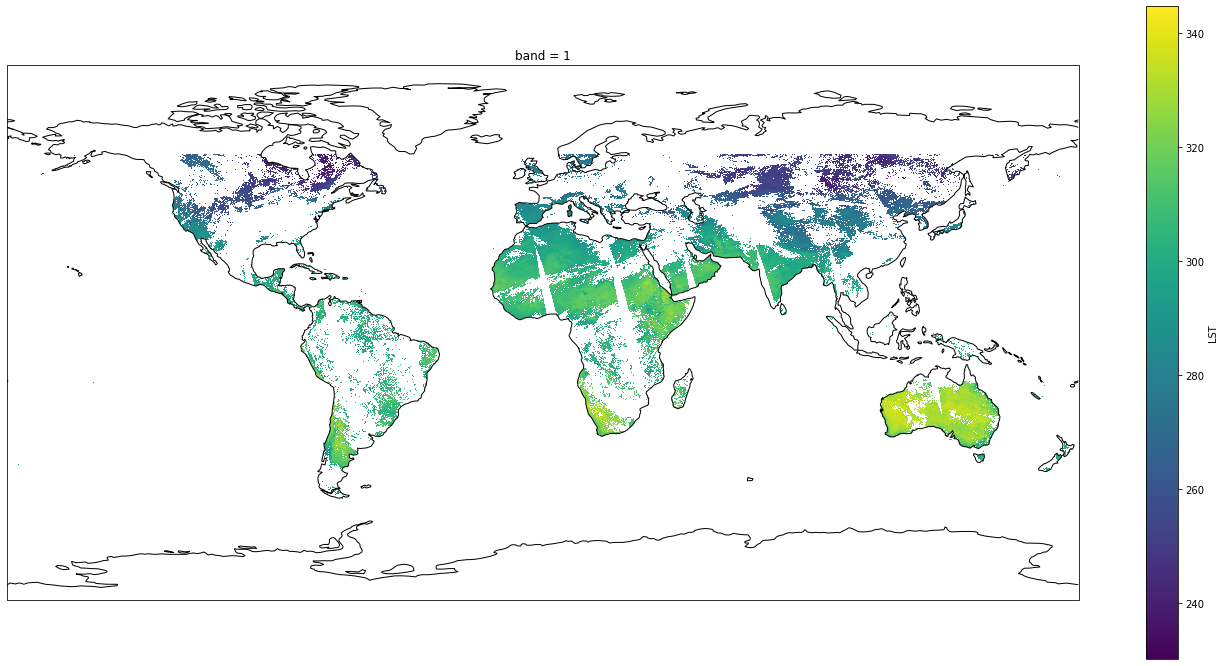

In [172]:
plotit(ds_MODIS,'LST')

* We have time as a 2d array. Would this be better as a coordinate?
* We have time at every lat/long would this be better null where the temperature is null?

In [107]:
# #Calculate the relevant time coordinates 
# UTC = UTC_time(da.x.data)
# dateUTC = absolute_datetime(root+f,UTC)

# #and assign new coords to dataarray
# da_new = da.assign_coords(UTC=('x', UTC),
#                           time=('x',dateUTC)
#                           )

# #Filter by latitude
# da_new = filter_by_latitude(da_new, 60)

# #assign to dataset
# ds_new = da_new.squeeze('band').to_dataset(name='LST')

# 3. Combining
We have the ERA data over a month and the MODIS data over a ~day.

We want to work on an hourly grain.

Lets grab an hour of MODIS data:


In [174]:
target = np.datetime64('2019-01-01T02:00:00.000000000')
time_filter = ds_MODIS.dateUTC == target
ds_MODIS_1hr = ds_MODIS.where(time_filter, drop=True)

and an hour of ERA...

In [198]:
ds_ERA_1hr = ds_ERA.sel(time = str(target))

In [256]:
ds_ERA_1hr

<xarray.Dataset>
Dimensions:     (values: 542080)
Coordinates:
    number      int64 0
    time        datetime64[ns] 2019-01-01T02:00:00
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    latitude    (values) float64 89.78 89.78 89.78 ... -89.78 -89.78 -89.78
    longitude   (values) float64 0.0 20.0 40.0 60.0 ... -80.0 -60.0 -40.0 -20.0
    valid_time  datetime64[ns] 2019-01-01T02:00:00
Dimensions without coordinates: values
Data variables:
    sp          (values) float32 1.005e+05 1.005e+05 ... 6.936e+04 6.928e+04
    msl         (values) float32 1.005e+05 1.005e+05 ... 9.979e+04 9.977e+04
    u10         (values) float32 1.768 -0.8591 -3.33 ... -1.845 -3.174 -4.083
    v10         (values) float32 -7.419 -7.602 -6.867 ... 3.878 2.958 1.599
    t2m         (values) float32 252.4 252.4 252.2 252.1 ... 244.4 244.4 244.5
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-01-25T15:10 GRIB to CDM+CF via cfgrib-0.9.9...

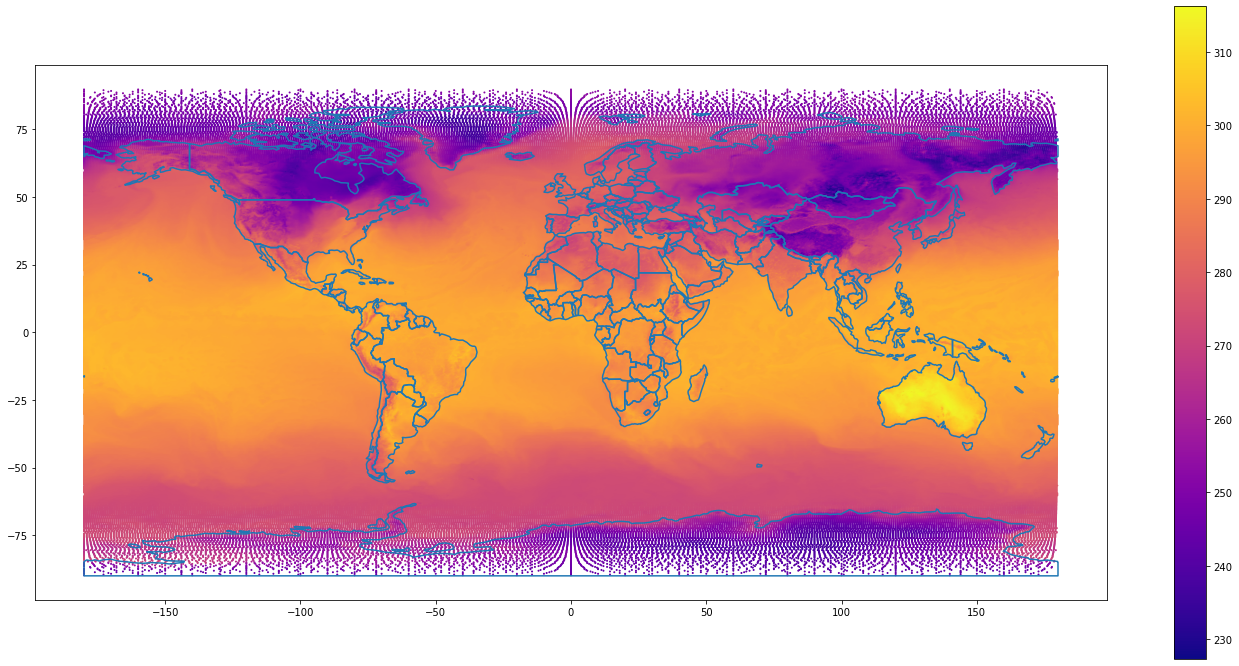

In [219]:
plotERA(ds_ERA_1hr,'t2m')

Note that the ERA data is indexed on time, so we can use `sel`, whereas the MODIS data is indexed on `y/x`

The ERA data covers the global surface, whilst the MODIS data only covers a subset - the points MODIS was able to observe within that hour.

It will prove useful to subset the ERA data to be within the bounds

In [232]:

max_long = ds_MODIS_1hr.x.data.max()
min_long = ds_MODIS_1hr.x.data.min()

max_lat = ds_MODIS_1hr.y.data.max()
min_lat = ds_MODIS_1hr.y.data.min()

longitude_filter = (ds_ERA_1hr.longitude < max_long) & (ds_ERA_1hr.longitude > min_long) 
latitude_filter = (ds_ERA_1hr.latitude < max_lat) & (ds_ERA_1hr.latitude > min_lat)
     
ds_ERA_1hr_spatial = ds_ERA_1hr.where(longitude_filter & latitude_filter, drop=True)



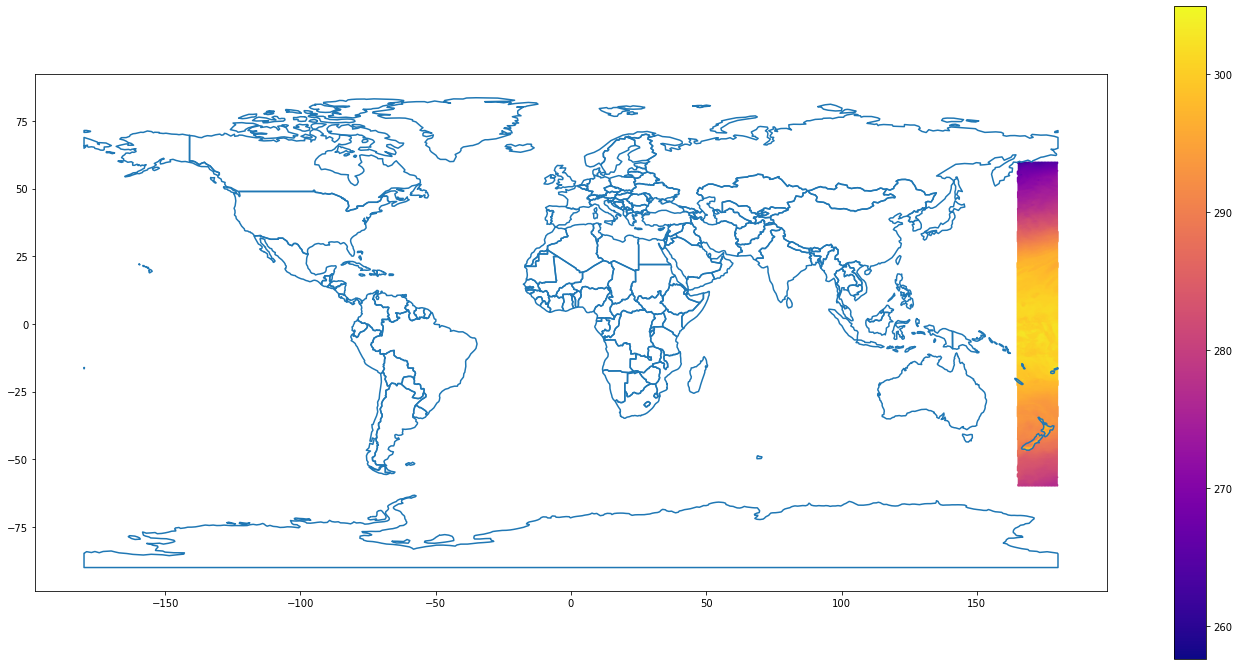

In [233]:
plotERA(ds_ERA_1hr_spatial,'t2m')

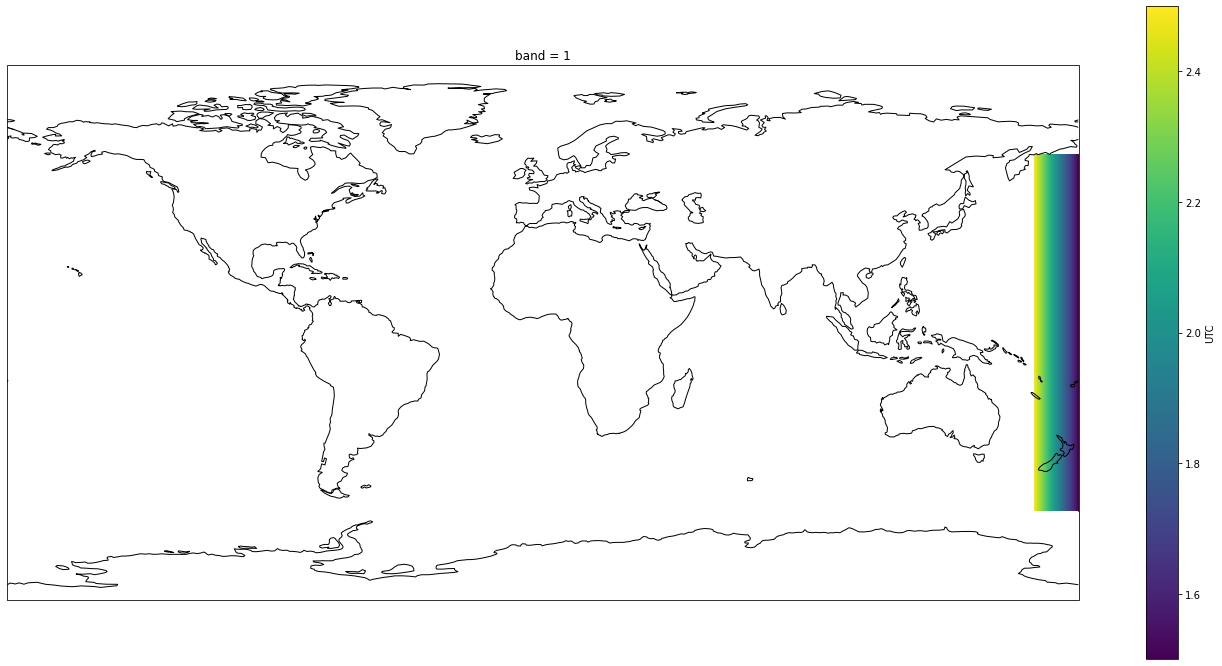

In [183]:
plotit(ds_MODIS_1hr,'UTC')

The ERA data covers the global surface, whilst the MODIS data only covers a subset - the points MODIS was able to observe within that hour.


---


Now, for every entry in `ERA1` we want to find the closest entry in `MODIS1`. This is a classic [nearest neighbours problem](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) which we can solve with inbuilt functions. We use the Haversine distance as our closeness metric. 

**This search is currently our most demanding step. How can we reduce this demand? No need to look in the entire ERA set...We could also potentially use query_radius...**

This general process can then be repeated for each hour snapshot.

---

# 3.1 Combining, but faster

It seems wasteful to find matching points over the entire ERA set since we are going to end up culling most of them due to the tolerance cutoffs.

Lets impose a trivial requirement on the ERA1 set to be within the longitude limits set by the MODIS1 set:

We can also use a generalisation of the above Ball Tree method to let the computer choose the best NN algo for the set of data

In [246]:
ERA1_selected = ds_ERA_1hr_spatial.to_dataframe()
MODIS1 = ds_MODIS_1hr.to_dataframe().reset_index()

In [242]:
ERA1_selected

,sp,msl,u10,v10,t2m,number,time,step,surface,latitude,longitude,valid_time
values,,,,,,,,,,,,
0,99616.710938,99633.9375,0.976791,-9.224762,258.925842,0,2019-01-01 02:00:00,0 days,0.0,59.71894,165.333333,2019-01-01 02:00:00
1,99500.710938,99558.1875,-0.314224,-10.398590,258.916077,0,2019-01-01 02:00:00,0 days,0.0,59.71894,165.866667,2019-01-01 02:00:00
2,99197.710938,99485.9375,0.427963,-9.698395,257.634827,0,2019-01-01 02:00:00,0 days,0.0,59.71894,166.400000,2019-01-01 02:00:00
3,99399.710938,99396.4375,-0.401138,-8.820465,260.849670,0,2019-01-01 02:00:00,0 days,0.0,59.71894,166.933333,2019-01-01 02:00:00
4,99308.710938,99351.9375,-1.299576,-7.142731,260.964905,0,2019-01-01 02:00:00,0 days,0.0,59.71894,167.466667,2019-01-01 02:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
19203,100101.710938,100104.1875,3.301010,-3.822418,276.845764,0,2019-01-01 02:00:00,0 days,0.0,-59.71894,177.600000,2019-01-01 02:00:00
19204,100122.710938,100120.9375,3.742416,-3.479645,276.826233,0,2019-01-01 02:00:00,0 days,0.0,-59.71894,178.133333,2019-01-01 02:00:00
19205,100126.710938,100131.1875,4.001205,-3.228668,277.027405,0,2019-01-01 02:00:00,0 days,0.0,-59.71894,178.666667,2019-01-01 02:00:00


In [248]:
%%time

from sklearn.neighbors import NearestNeighbors
import numpy as np

# Setup NearestNeighbours using MODIS as reference dataset
# Use Haversine calculate distance between points on the earth from lat/long
NN = NearestNeighbors(n_neighbors=1, metric='haversine') #algorithm = balltree, kdtree or brutie force


NN.fit(np.deg2rad(MODIS1[['y', 'x']].values))


query_lats = ERA1_selected['latitude'].astype(np.float64)
query_lons = ERA1_selected['longitude'].astype(np.float64)
X = np.deg2rad(np.c_[query_lats, query_lons])
distances, indices = NN.kneighbors(X, return_distance=True)


r_km = 6371 # multiplier to convert to km (from unit distance)
distances = distances*r_km





CPU times: user 1.97 s, sys: 372 ms, total: 2.35 s
Wall time: 2.34 s


In [249]:

#Combine both dfs
df_combined = ERA1_selected.reset_index().join(MODIS1.iloc[indices.flatten()].reset_index(), lsuffix='_ERA',rsuffix='_MODIS')
df_combined['distance'] = distances
df_combined['MODIS_idx'] = indices

#Filter and surface selected columns
#We have set the cutoff arbitratily as 1
df_combined_matches = df_combined.query('distance < 1')
display(df_combined_matches)

,values,sp,msl,u10,v10,t2m,number,time,step,surface,...,valid_time,index,y,x,LST,UTC,dateUTC,band,distance,MODIS_idx
0,0,99616.710938,99633.9375,0.976791,-9.224762,258.925842,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,3610,59.716667,165.350000,NaN,2.476667,2019-01-01 02:00:00,1,0.968093,3610
1,1,99500.710938,99558.1875,-0.314224,-10.398590,258.916077,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,3626,59.716667,165.883333,NaN,2.441111,2019-01-01 02:00:00,1,0.968093,3626
2,2,99197.710938,99485.9375,0.427963,-9.698395,257.634827,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,3641,59.716667,166.383333,NaN,2.407778,2019-01-01 02:00:00,1,0.968093,3641
3,3,99399.710938,99396.4375,-0.401138,-8.820465,260.849670,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,3658,59.716667,166.950000,NaN,2.370000,2019-01-01 02:00:00,1,0.968093,3658
4,4,99308.710938,99351.9375,-1.299576,-7.142731,260.964905,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,3674,59.716667,167.483333,NaN,2.334444,2019-01-01 02:00:00,1,0.968093,3674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19203,19203,100101.710938,100104.1875,3.301010,-3.822418,276.845764,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,1616328,-59.716667,177.616667,NaN,1.658889,2019-01-01 02:00:00,1,0.968093,1616328
19204,19204,100122.710938,100120.9375,3.742416,-3.479645,276.826233,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,1616343,-59.716667,178.116667,NaN,1.625556,2019-01-01 02:00:00,1,0.968093,1616343
19205,19205,100126.710938,100131.1875,4.001205,-3.228668,277.027405,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,1616359,-59.716667,178.650000,NaN,1.590000,2019-01-01 02:00:00,1,0.968093,1616359
19206,19206,100133.710938,100141.1875,3.899643,-3.046051,277.269592,0,2019-01-01 02:00:00,0 days,0.0,...,2019-01-01 02:00:00,1616375,-59.716667,179.183333,NaN,1.554444,2019-01-01 02:00:00,1,0.968093,1616375


<AxesSubplot:>

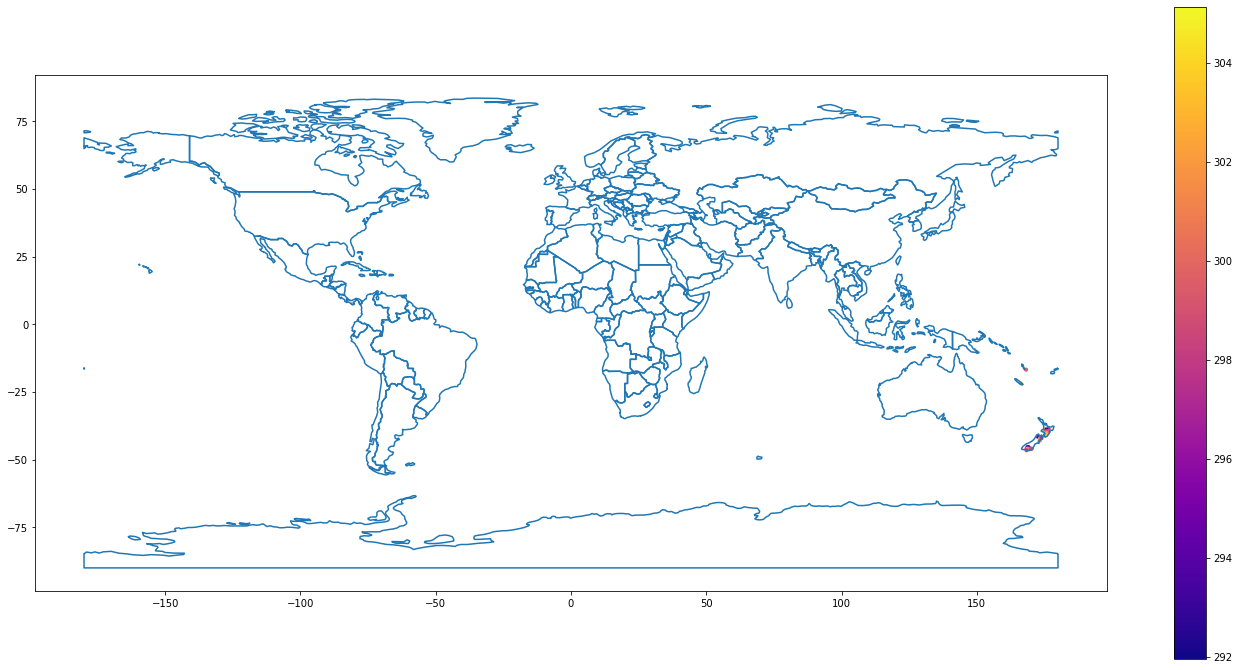

In [252]:
df = df_combined_matches
q = 'LST'
#Plot land outlines
ax=world.boundary.plot(figsize=(24,12))

#Create geopandas
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#Plot it
gdf.plot(ax=ax,column=q, cmap='plasma', legend=True,markersize=10)




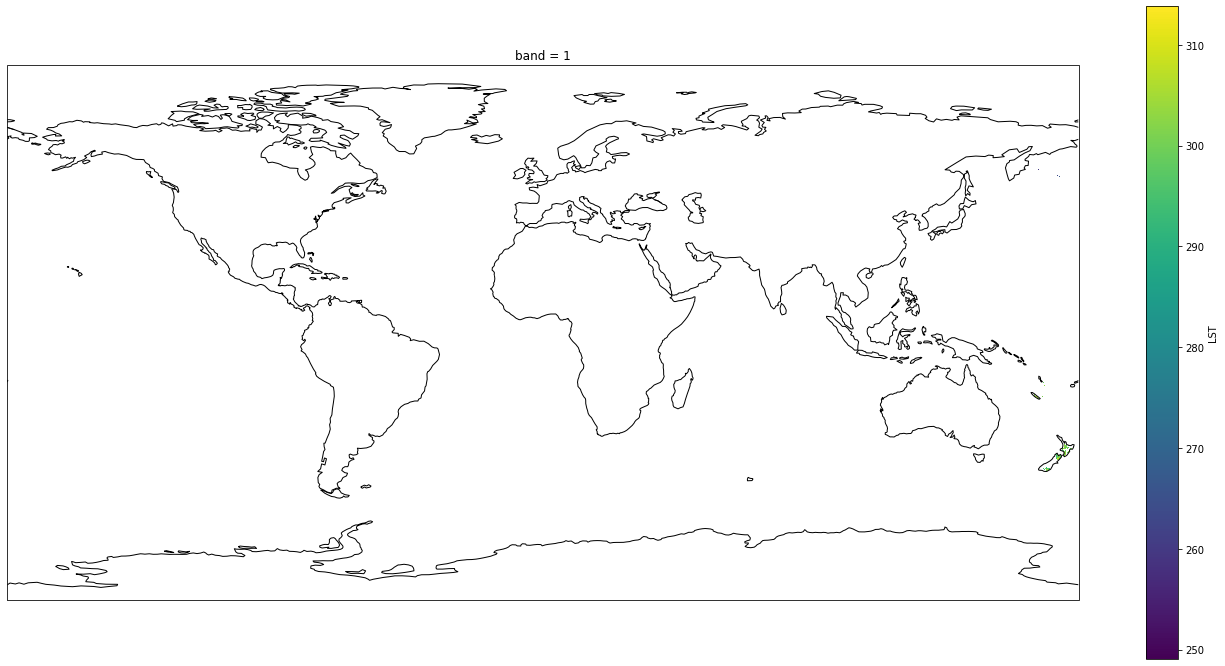

In [253]:
plotit(ds_MODIS_1hr,'LST')



# Appendix A - MODIS snapshots at each hour over 1 day

# Scratch space

---

In [88]:
def haversine_np(lon1, lat1, lon2, lat2):
    
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [89]:
haversine_np(171.116667,70.05,174.0,69.55)

123.78902425712415

In [ ]:
%time
reference_time = 13.5 #Hours. Equatorial crossing time, local solar time
ref_data = np.ones((ds_MODIS.sizes['y'], ds_MODIS.sizes['x'])) * reference_time #array of 
new = ds_MODIS.LST.copy(data=ref_data)


out = new - new.x/15

out = out.round()